In [1]:
# !pip install pystan
# !pip install fbprophet
# !pip install plotly
# !pip install ipywidgets
"""
ref: prophet docs
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json


# State %-production share

# MAHARASHTRA 29.59
# MADHYA PRADESH 15.16
# KARNATAKA 13.64
# GUJARAT 6.42
# BIHAR 6.25
# RAJASTHAN 4.80
# ANDHRA PRADESH 5.02
# source: http://agricoop.gov.in/sites/default/files/Monthly%20Report%20on%20Onion%20for%20May%2C%202018.pdf



$$y(t)=g(t)+s(t)+h(t)+\epsilon _t$$
$$g(t)=\frac{C}{1+}$$
$$s(t)=\sum_{n=1}^{N}\bigg(a_n \cos\Big(\frac{2\pi nt}{P}\Big) + b_n \sin\Big(\frac{2\pi nt}{P}\Big)\bigg)$$
$$$$

```

In [2]:
df = pd.read_csv('full_onion_data.csv')
df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
       'MIN', 'MAX'], axis= 1)
df['ds'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
df['y'] = df['MODAL'].apply(lambda x: int(x))
df = df.sort_values(by=['ds'])

In [3]:
df.dtypes

MODAL           float64
DATE             object
ds       datetime64[ns]
y                 int64
dtype: object

In [4]:
df.head()

,MODAL,DATE,ds,y
2681,1250.0,01 Jan 2010,2010-01-01,1250
2680,1375.0,02 Jan 2010,2010-01-02,1375
2679,1150.0,04 Jan 2010,2010-01-04,1150
2678,1125.0,05 Jan 2010,2010-01-05,1125
2677,1150.0,07 Jan 2010,2010-01-07,1150


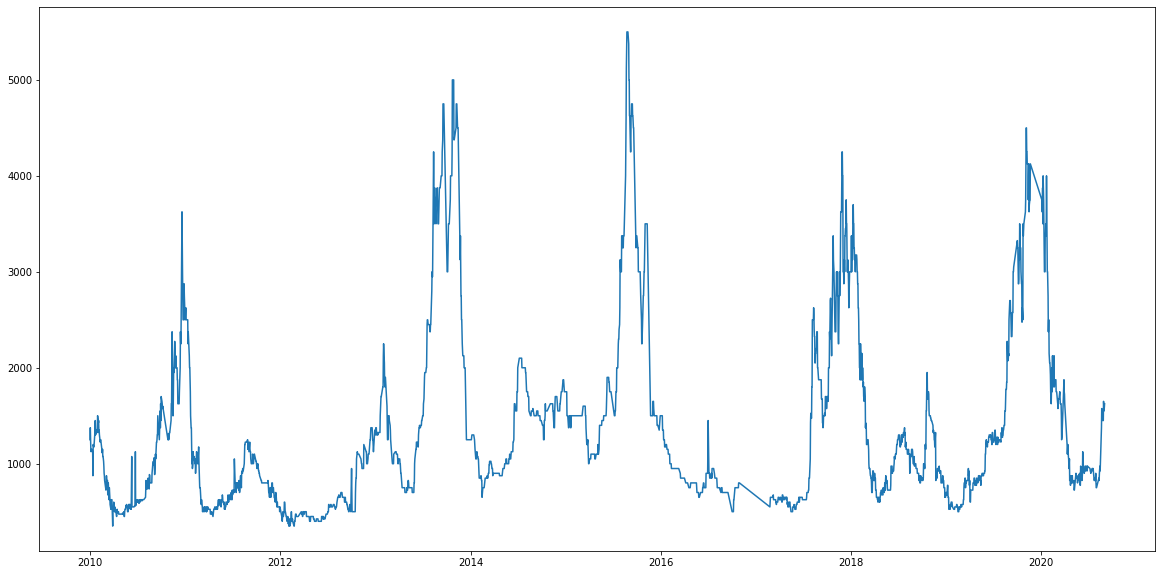

In [5]:
plt.figure(figsize=(20,10))
plt.plot(df['ds'], df['y'])
plt.show()

In [6]:
m = Prophet()
# Prophet.add_country_holidays(m, "India")
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [7]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
2684,2020-09-03
2685,2020-09-04
2686,2020-09-05
2687,2020-09-06
2688,2020-09-07


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2684,2020-09-03,2473.862178,1634.307084,3303.817081
2685,2020-09-04,2474.328759,1629.955918,3299.229754
2686,2020-09-05,2460.054047,1655.350042,3335.459453
2687,2020-09-06,2515.186900,1701.897330,3400.758331
2688,2020-09-07,2486.313917,1655.512819,3337.539142


In [9]:
# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  # Save model

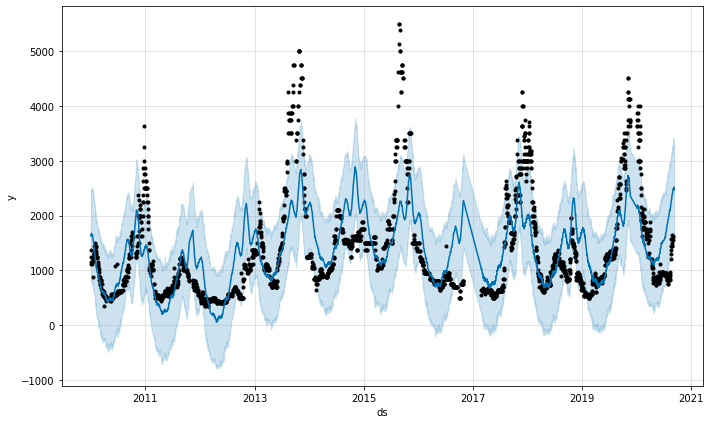

In [10]:
fig1 = m.plot(forecast)

In [25]:
f2 = forecast.copy()
f2['orj'] = pd.Series(df['y'].to_numpy())
def tst(C1, C2, C, D):

    for i in range(1, len(forecast)//7-7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][len(df)-1-j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][len(df)-1-j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):
                # current_yhat, prev_yhat_prophet, prev_yhat_f2,
                # prev_data
                # yhat_lower_curr, yhat_upper_curr
                # yhat_lower_prev, yhat_upper_prev
                # cnt
                
                # forecast['yhat_lower'][j], forecast['yhat_upper'][j],
                # forecast['yhat_lower'][j-7], forecast['yhat_upper'][j-7],

                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * df['y'][len(df)-1-j+7] 
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return (f2['sqe'].sum()/len(f2['sqe']-7))**(1/2)


In [39]:
import numpy as np
X1 = np.linspace(0.1, 1, num=10)
X2 = np.linspace(0.1, 1, num=10)
X3 = np.linspace(0.1, 1, num=10)
D1 = [0.1,0.2,0.3]
D2 = [0.1,0.2,0.3]
counter = 0
rmses = []
for d1 in D1:
    for d2 in D2:    
        for x1 in X1:
            for x2 in X2:
                for x3 in X3:

                    if x1+x2+x3+d1+d2!=1:
                        pass
#                     print([x1,x2,x3],[d1,d2])
                    rmses.append(([x1,x2,x3],[d1,d2],tst(0.25,3,[x1,x2,x3],[d1,d2])))
                    if len(rmses)>10**8:
                        break
                break
            break
        break
    break
                

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
rmses.sort(key= lambda x: x[2])

In [41]:
rmses[:10]

[([0.1, 0.1, 0.6], [0.1, 0.1], 375.956659866217),
 ([0.1, 0.1, 0.7000000000000001], [0.1, 0.1], 392.62360705573474),
 ([0.1, 0.1, 0.5], [0.1, 0.1], 416.4214194708803),
 ([0.1, 0.1, 0.8], [0.1, 0.1], 460.25694862025006),
 ([0.1, 0.1, 0.4], [0.1, 0.1], 500.3433444212057),
 ([0.1, 0.1, 0.9], [0.1, 0.1], 560.7074958523963),
 ([0.1, 0.1, 0.30000000000000004], [0.1, 0.1], 610.0437699338676),
 ([0.1, 0.1, 1.0], [0.1, 0.1], 679.575314643624),
 ([0.1, 0.1, 0.2], [0.1, 0.1], 734.0549130546897),
 ([0.1, 0.1, 0.1], [0.1, 0.1], 866.2523331803525)]

In [42]:
tst(0.25,3, [0.1, 0.1, 0.6], [0.1, 0.1])

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/siram/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



375.956659866217

In [43]:
plot_plotly(m, f2)

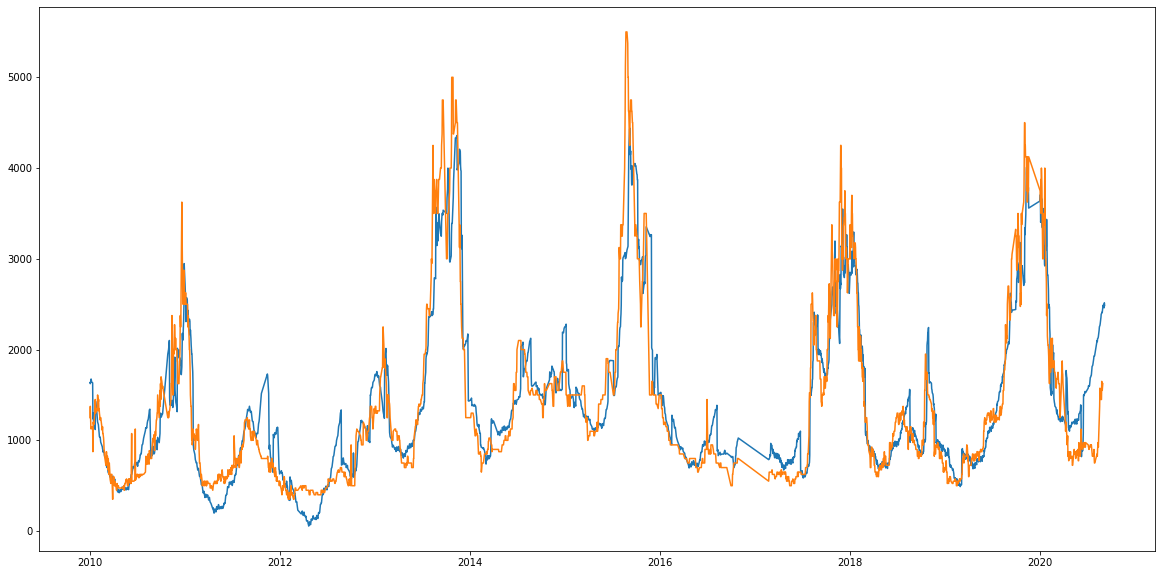

In [44]:
plt.figure(figsize=(20,10))
plt.plot(f2['ds'], f2['yhat'])
plt.plot(df['ds'], df['y'])
# plt.plot(dfl_t[i]['ds'], dfl_t[i]['y'])
plt.show()

In [75]:
f2['orj'] = pd.Series(df['y'].to_numpy())

<AxesSubplot:>

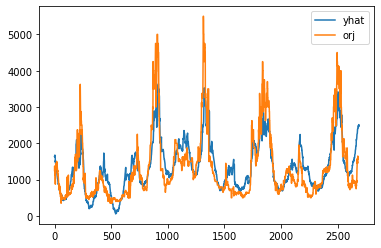

In [76]:
f2[['yhat', 'orj']].plot()

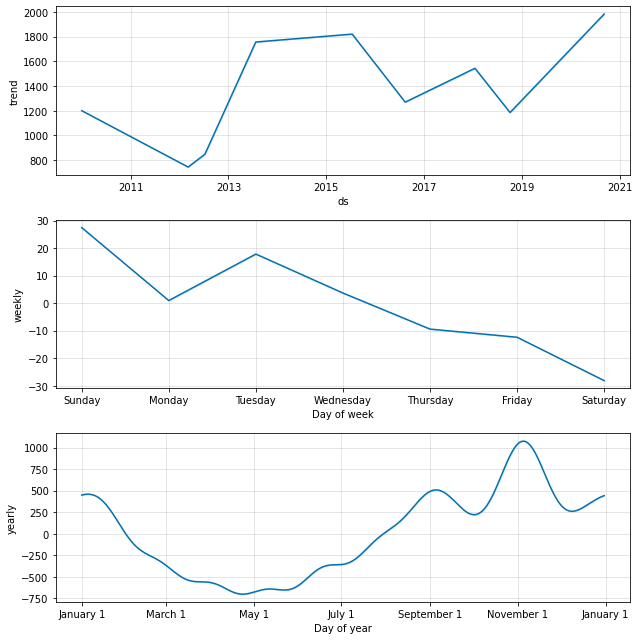

In [14]:
fig2 = m.plot_components(f2)

In [15]:
plot_plotly(m, f2)

In [16]:
plot_components_plotly(m, f2)